## Table of contents:
* [Exploring data](#exploring-data)
* [Dealing with outliers](#outliers)
* [Eliminating unnecessary features](#features)
* [Building a dataset](#datasets)
* [Defining models](#models)
* [Training and evaluation](#training)

## Exploring data <a class="anchor" id="exploring-data"></a>

In [1]:
import numpy as np
import os
import partitura as pt
from basismixer.performance_codec import get_performance_codec
from matplotlib import pyplot as plt
import glob
import re
from scipy import stats
import json
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from torch.utils.data import Subset
import torch
import pathlib

from typing import Union, Tuple, List, Iterable, Any, Dict, Optional

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

from partitura import load_score, load_match
from partitura.score import expand_grace_notes
from basismixer.utils import pair_files, get_unique_onset_idxs, notewise_to_onsetwise
from basismixer.performance_codec import get_performance_codec
from partitura.performance import PerformedPart
from pathlib import Path
from multiprocessing import Pool

from partitura.score import GraceNote, Note, Part
from partitura.utils.misc import PathLike

from basismixer.performance_codec import PerformanceCodec

EXPRESSIVE_PARAMS = ["beat_period_ratio",
                     "timing",
                     "articulation_log",
                     "beat_period_mean",
                     "velocity_trend",
                     "velocity_dev"]

In [2]:
def remove_grace_notes(part: Part) -> None:
    """
    Remove all grace notes from a Part.

    The specified Part object will be modified in place.

    Parameters
    ----------
    part : Part
        The score part from which to remove the grace notes

    """
    for gn in list(part.iter_all(GraceNote)):
        for n in list(part.iter_all(Note)):
            if n.tie_next == gn:
                n.tie_next = None
        part.remove(gn)

In [2]:
xml_fn = glob.glob(os.path.join("asap-dataset", "**", "*.musicxml"), recursive=True)
match_blacklist = []
# piece 213 leads to errors when unfolding
match_blacklist.append(xml_fn.pop(213))
dump_json = False
perf_parameters = []
all_feature_names = set()

parameter_names = EXPRESSIVE_PARAMS
pc = get_performance_codec(parameter_names)

for xml in tqdm(xml_fn):
    
    match_fn = glob.glob(os.path.join(os.path.dirname(xml), "*.match"))

    score = pt.load_score(xml)
    # should parts be merged??
    score = pt.score.merge_parts(score)
    
    # not needed apparently
    # score = pt.score.unfold_part_maximal(score, update_ids=True)

    for match in match_fn:

        try:
            performance, alignment = pt.load_match(match)
    
            pt.score.expand_grace_notes(score)
        
            part = pt.score.unfold_part_alignment(part=score, alignment=alignment)
    
            basis, bf_names = pt.musicanalysis.make_note_feats(part, "all", force_fixed_size=True)
            all_feature_names.update(bf_names)
            
            nid_dict = dict((n.id, i) for i, n in enumerate(part.notes_tied))

            targets, snote_ids, unique_onset_idxs = pc.encode(
                part=part,
                ppart=performance[0],
                alignment=alignment,
                return_u_onset_idx=True
            )
            
            matched_subset_idxs = np.array([nid_dict[nid] for nid in snote_ids])
            basis_matched = basis[matched_subset_idxs]
            
            perf_parameters.append((targets, match))

        except Exception as e:
            print(e)
            print(match)
            match_blacklist.append(match)
            continue

  0%|▎                                                                                 | 1/234 [00:02<09:45,  2.51s/it]


KeyboardInterrupt: 

In [ ]:
xml_fn[212], xml_fn[213], xml_fn[214]

In [3]:
perf_parameters[0][0].dtype

dtype([('beat_period_ratio', '<f4'), ('timing', '<f4'), ('articulation_log', '<f4'), ('beat_period_mean', '<f4'), ('velocity_trend', '<f4'), ('velocity_dev', '<f4')])

## Dealing with outliers <a class="anchor" id="outliers"></a>

In [ ]:
def clip_parameters(array, bpr=[0, 2.5], t=[-0.1, 0.1]):
    copy = array.copy()
    
    for perf, name in copy:
        if "beat_period_ratio" in perf.dtype:
            np.clip(targets["beat_period_ratio"], a_min=0, a_max=6, out=targets["beat_period_ratio"])
        if "timing" in perf.dtype:
            np.clip(targets["timing"], a_min=-1, a_max=1, out=targets["timing"])
        if "beat_period" in perf.dtype:
            np.clip(targets["beat_period"], a_min=0, a_max=3, out=targets["beat_period"])
        
    return copy

In [7]:
import pandas as pd

indices = [perf[1] for perf in perf_parameters]
expressiveness_params = EXPRESSIVE_PARAMS
descriptions = []
dataframes = []

perf_parameters = clip_parameters(perf_parameters, t=[-1, 1], bpr=[0, 6])

for perf in perf_parameters:
    param_df = pd.DataFrame(perf[0], columns=expressiveness_params)
    dataframes.append(param_df)
    descriptions.append(param_df.describe())

In [8]:
def get_outliers(z_threshold=3):
    
    outlier_dict = {"piece_names": []}
    
    for param_name in expressiveness_params:

        print(f"{param_name} outliers:")

        param_df = pd.DataFrame(columns=["min", "max", "mean"], index=indices)

        param_df["min"] = [desc[param_name].T["min"] for desc in descriptions]
        param_df["max"] = [desc[param_name].T["max"] for desc in descriptions]
        param_df["mean"] = [desc[param_name].T["mean"] for desc in descriptions]
        
        min_mean = np.mean(param_df["min"])
        max_mean = np.mean(param_df["max"])
        mean_mean = np.mean(param_df["mean"])
        
        min_median = np.median(param_df["min"])
        max_median = np.median(param_df["max"])
        mean_median = np.median(param_df["mean"])

        z_min = np.abs(stats.zscore(param_df["min"]))
        z_max = np.abs(stats.zscore(param_df["max"]))
        z_mean = np.abs(stats.zscore(param_df["max"]))
        
        outliers = param_df[(z_min > z_threshold) | (z_max > z_threshold) | (z_mean > z_threshold)]
        
        print(f"""Mean values for comparison:
                    min: {min_mean}
                    max: {max_mean}
                    mean: {mean_mean}\n""")
        
        print(f"""Median values for comparison:
                    min: {min_median}
                    max: {max_median}
                    mean: {mean_median}\n""")
        
        print(f"{outliers.to_markdown()}\n\n")
        outlier_dict[param_name] = outliers
        outlier_dict["piece_names"] += [idx for idx in outliers.index]
        
    return outlier_dict

In [9]:
outlier_dict = get_outliers(6)
outlier_dict["piece_names"] += match_blacklist
outlier_dict["piece_names"] = list(set(outlier_dict["piece_names"]))

beat_period_ratio outliers:
Mean values for comparison:
                    min: 0.1361704734177525
                    max: 4.929475160206065
                    mean: 1.0081629676769084

Median values for comparison:
                    min: 0.046032095327973366
                    max: 5.750697374343872
                    mean: 1.0071123242378235

| min   | max   | mean   |
|-------|-------|--------|


timing outliers:
Mean values for comparison:
                    min: -0.5537110822702948
                    max: 0.5229778194904285
                    mean: 0.0003838620213122546

Median values for comparison:
                    min: -0.5073324739933014
                    max: 0.46107006072998047
                    mean: 0.0

| min   | max   | mean   |
|-------|-------|--------|


articulation_log outliers:
Mean values for comparison:
                    min: -4.034457930351344
                    max: 6.9230732465378475
                    mean: 0.6577803475110844

Median valu

In [10]:
outlier_dict["piece_names"]

['asap-dataset\\Debussy\\Pour_le_Piano\\1\\MunA12M.match']

In [13]:
from matplotlib import pyplot as plt

for param_name in expressiveness_params:
    
    if len(outlier_dict[param_name]) != 0:
    
        fig, ax = plt.subplots(len(outlier_dict[param_name])+1, figsize=(10, 20))
        for i, piece_name in enumerate(outlier_dict[param_name].index):

            idx = indices.index(piece_name)
            df = dataframes[idx]

            ax[i].plot(df[param_name])
            ax[i].set(title=f"{param_name.upper()}: {piece_name}")

        fig.tight_layout()

In [14]:
valid_perf_params = [perf for perf in perf_parameters if perf[1] not in outlier_dict["piece_names"]]

print(len(perf_parameters), len(valid_perf_params))

1054 1054


## Eliminating unnecessary features <a class="anchor" id="features"></a>

In [15]:
all_feature_names

{'articulation_direction_feature.accent',
 'articulation_direction_feature.marcato',
 'articulation_direction_feature.staccato',
 'articulation_direction_feature.tenuto',
 'articulation_direction_feature.unknown_articulation',
 'articulation_feature.accent',
 'articulation_feature.breath-mark',
 'articulation_feature.caesura',
 'articulation_feature.detached-legato',
 'articulation_feature.doit',
 'articulation_feature.falloff',
 'articulation_feature.plop',
 'articulation_feature.scoop',
 'articulation_feature.soft-accent',
 'articulation_feature.spiccato',
 'articulation_feature.staccatissimo',
 'articulation_feature.staccato',
 'articulation_feature.stress',
 'articulation_feature.strong-accent',
 'articulation_feature.tenuto',
 'articulation_feature.unstress',
 'duration_feature.duration',
 'fermata_feature.fermata',
 'grace_feature.grace_note',
 'grace_feature.grace_pos',
 'grace_feature.n_grace',
 'loudness_direction_feature.f',
 'loudness_direction_feature.ff',
 'loudness_direct

In [18]:
basis_list = []
feature_names = None

counter = 0
for perf, perf_name in tqdm(valid_perf_params):
    
    xml = glob.glob(os.path.join(os.path.dirname(perf_name), "*.musicxml"))[0]
    
    score = pt.load_score(xml)
    score = pt.score.merge_parts(score)
    
    match_fn = glob.glob(os.path.join(os.path.dirname(xml), "*.match"))
    match = match_fn[0]
        
    performance, alignment = pt.load_match(match)

    pt.score.expand_grace_notes(score)

    part = pt.score.unfold_part_alignment(part=score, alignment=alignment)

    basis, bf_names = pt.musicanalysis.make_note_feats(part, "all", force_fixed_size=True)
    basis = np.mean(basis, axis=0)
    basis_list.append(basis)
    
    feature_names = bf_names

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1021/1054 [1:09:50<03:15,  5.93s/it]

snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n178-1,[B,b],4,16:1,1/10,-1/28,28.388671875,28.25,[])-note(n166,[B,b],4,13799,13860,14020,70). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n178-1,[B,b],4,16:1,1/10,-1/28,28.388671875,28.25,[])-no

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1022/1054 [1:09:52<02:30,  4.70s/it]

snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n178-1,[B,b],4,16:1,1/10,-1/28,28.388671875,28.25,[])-note(n166,[B,b],4,13799,13860,14020,70). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n178-1,[B,b],4,16:1,1/10,-1/28,28.388671875,28.25,[])-no

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1023/1054 [1:09:55<02:06,  4.09s/it]

snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n178-1,[B,b],4,16:1,1/10,-1/28,28.388671875,28.25,[])-note(n166,[B,b],4,13799,13860,14020,70). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n178-1,[B,b],4,16:1,1/10,-1/28,28.388671875,28.25,[])-no

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1054/1054 [1:31:36<00:00,  5.22s/it]


In [19]:
df = pd.DataFrame(np.vstack(basis_list), columns=bf_names)
df.corr()

,articulation_direction_feature.staccato,articulation_direction_feature.tenuto,articulation_direction_feature.accent,articulation_direction_feature.marcato,articulation_direction_feature.unknown_articulation,articulation_feature.accent,articulation_feature.strong-accent,articulation_feature.staccato,articulation_feature.tenuto,articulation_feature.detached-legato,...,tempo_direction_feature.prestissimo,tempo_direction_feature.unknown_constant,tempo_direction_feature.tempo_incr,tempo_direction_feature.tempo_decr,vertical_neighbor_feature.n_total,vertical_neighbor_feature.n_above,vertical_neighbor_feature.n_below,vertical_neighbor_feature.highest_pitch,vertical_neighbor_feature.lowest_pitch,vertical_neighbor_feature.pitch_range
articulation_direction_feature.staccato,1.000000,NaN,NaN,NaN,-0.039790,0.026185,0.488048,0.384375,0.091768,0.514936,...,0.074663,0.024795,-0.041760,-0.008861,0.123763,0.110842,0.110842,0.331753,0.240464,0.083885
articulation_direction_feature.tenuto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
articulation_direction_feature.accent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
articulation_direction_feature.marcato,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
articulation_direction_feature.unknown_articulation,-0.039790,NaN,NaN,NaN,1.000000,-0.036105,-0.020237,-0.016556,-0.038251,-0.041006,...,-0.022021,0.094335,-0.046326,-0.023202,0.011797,0.012468,0.012468,0.019739,-0.070366,0.093687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vertical_neighbor_feature.n_above,0.110842,NaN,NaN,NaN,0.012468,0.116347,0.252082,0.259208,0.193769,0.061628,...,0.050661,0.311166,0.310523,0.246314,0.998417,1.000000,1.000000,0.374331,-0.429645,0.828925
vertical_neighbor_feature.n_below,0.110842,NaN,NaN,NaN,0.012468,0.116347,0.252082,0.259208,0.193769,0.061628,...,0.050661,0.311166,0.310523,0.246314,0.998417,1.000000,1.000000,0.374331,-0.429645,0.828925
vertical_neighbor_feature.highest_pitch,0.331753,NaN,NaN,NaN,0.019739,0.157994,0.510268,0.307460,0.047502,0.503843,...,0.033578,0.020219,0.142077,-0.050441,0.374168,0.374331,0.374331,1.000000,0.528984,0.458002
vertical_neighbor_feature.lowest_pitch,0.240464,NaN,NaN,NaN,-0.070366,-0.040263,0.306366,0.120675,0.022354,0.426636,...,0.024495,-0.228540,-0.161469,-0.224449,-0.421874,-0.429645,-0.429645,0.528984,1.000000,-0.512116


In [103]:
corr_matrix = df.corr().fillna(0)
drop_cols = []

for j, col in enumerate(corr_matrix.columns):
    
    if col not in drop_cols:
    
        feature_index = corr_matrix.columns.get_loc(col)
        other_feature_corrs = corr_matrix[col][:feature_index:]
        high_feature_corrs = other_feature_corrs[other_feature_corrs.abs() > 0.9]

        drop_cols += list(high_feature_corrs.index)
        
        # checking if any correlation can be computed; if not -> feature is all zeros and can be removed
        if np.max(other_feature_corrs) == 0:
            drop_cols.append(col)
            print(f"{col} is all zeroes")
            
        elif len(list(high_feature_corrs)) > 0:
            print(f"{col} has the highest correlation with {list(high_feature_corrs.index)}, {list(high_feature_corrs)}\n")

articulation_direction_feature.tenuto is all zeroes
articulation_direction_feature.accent is all zeroes
articulation_direction_feature.marcato is all zeroes
articulation_direction_feature.unknown_articulation is all zeroes
articulation_feature.spiccato is all zeroes
articulation_feature.scoop is all zeroes
articulation_feature.plop is all zeroes
articulation_feature.doit is all zeroes
articulation_feature.falloff is all zeroes
articulation_feature.breath-mark is all zeroes
articulation_feature.stress is all zeroes
articulation_feature.unstress is all zeroes
articulation_feature.soft-accent is all zeroes
grace_feature.grace_pos has the highest correlation with ['grace_feature.n_grace'], [0.9828821899746245]

metrical_strength_feature.metrical_strength_downbeat has the highest correlation with ['metrical_strength_feature.beat_phase'], [-0.9257578456952602]

metrical_strength_feature.metrical_strength_weak has the highest correlation with ['metrical_strength_feature.beat_phase', 'metrical

In [104]:
new_df = df.drop(columns=drop_cols)
len(new_df.columns)

new_features = list(new_df.columns)

In [105]:
len(new_features)

58

In [2]:
drop_cols

NameError: name 'drop_cols' is not defined

<Axes: >

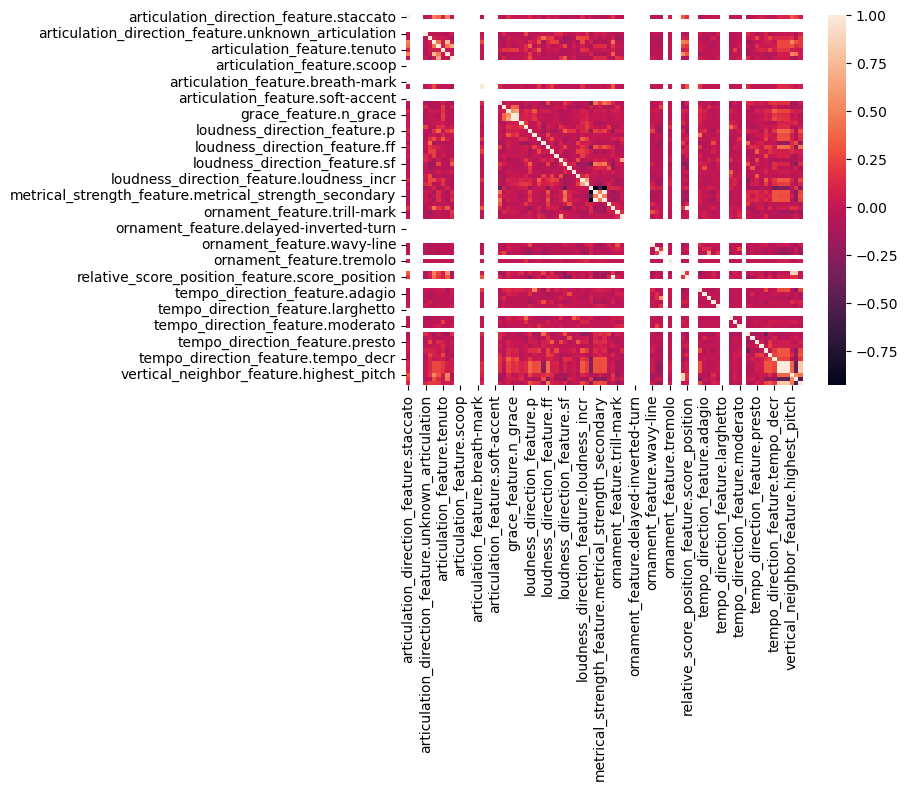

In [107]:
import seaborn as sns

sns.heatmap(df.corr())

<Axes: >

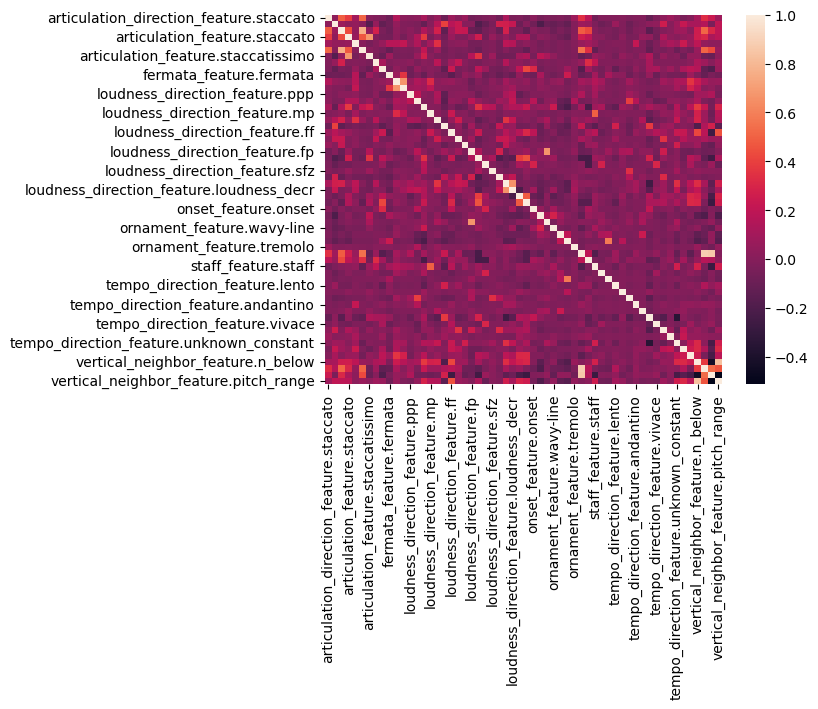

In [108]:
sns.heatmap(new_df.corr())

In [109]:
with open("better_features.txt", "w") as f:
    for feat in new_features:
        f.write(feat + "\n")

In [2]:
drop_cols = None

with open("drop_feats.txt") as f:
    drop_cols = f.read().splitlines()

drop_cols

['articulation_direction_feature.tenuto',
 'articulation_direction_feature.accent',
 'articulation_direction_feature.marcato',
 'articulation_feature.spiccato',
 'articulation_feature.scoop',
 'articulation_feature.plop',
 'articulation_feature.doit',
 'articulation_feature.falloff',
 'articulation_feature.breath-mark',
 'articulation_feature.stress',
 'articulation_feature.unstress',
 'articulation_feature.soft-accent',
 'grace_feature.grace_pos',
 'metrical_strength_feature.metrical_strength_downbeat',
 'metrical_strength_feature.metrical_strength_weak',
 'ornament_feature.delayed-turn',
 'ornament_feature.inverted-turn',
 'ornament_feature.delayed-inverted-turn',
 'ornament_feature.vertical-turn',
 'ornament_feature.inverted-vertical-turn',
 'ornament_feature.shake',
 'ornament_feature.schleifer',
 'ornament_feature.haydn',
 'ornament_feature.other-ornament',
 'relative_score_position_feature.score_position',
 'slur_feature.slur_incr',
 'slur_feature.slur_decr',
 'tempo_direction_fe

In [5]:
with open("better_features.txt", "r") as f:
    new_features = f.read().splitlines()
    
new_features, len(new_features)

(['articulation_direction_feature.staccato',
  'articulation_feature.accent',
  'articulation_feature.strong-accent',
  'articulation_feature.staccato',
  'articulation_feature.tenuto',
  'articulation_feature.detached-legato',
  'articulation_feature.staccatissimo',
  'articulation_feature.caesura',
  'duration_feature.duration',
  'fermata_feature.fermata',
  'grace_feature.grace_note',
  'grace_feature.grace_pos',
  'loudness_direction_feature.ppp',
  'loudness_direction_feature.pp',
  'loudness_direction_feature.p',
  'loudness_direction_feature.mp',
  'loudness_direction_feature.mf',
  'loudness_direction_feature.f',
  'loudness_direction_feature.ff',
  'loudness_direction_feature.fff',
  'loudness_direction_feature.unknown_constant',
  'loudness_direction_feature.fp',
  'loudness_direction_feature.sf',
  'loudness_direction_feature.sfp',
  'loudness_direction_feature.sfz',
  'loudness_direction_feature.unknown_impulsive',
  'loudness_direction_feature.loudness_incr',
  'loudness_

## Building a dataset <a class="anchor" id="datasets"></a>

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    
    def __init__(self,
                 xml_paths,
                 seq_len, param_names=["beat_period_ratio",
                                       "timing",
                                       "articulation_log",
                                       "beat_period_mean",
                                       "velocity_trend",
                                       "velocity_dev"],
                 fixed_features=True,
                 feat_names="all",
                 drop_feats=[]
                ):   
        
        self.xml_paths = xml_paths
        self.data = []
        self.target_data = None
        self.param_names = param_names
        self.parameter_dict = {name: [] for name in param_names}
        self.expressive_params = param_names
        
        self.feature_size = 0
        self.seq_len = seq_len
        
        pc = get_performance_codec(param_names)
        
        print("Processing score data...")
        for xml in tqdm(xml_paths):

            score = pt.load_score(xml)
            score = pt.score.merge_parts(score)
            pt.score.expand_grace_notes(score)
            
            for match_file in glob.glob(os.path.join(os.path.dirname(xml), "*.match")):
                
                try:
                    performance, alignment = pt.load_match(match_file)
                    part = pt.score.unfold_part_alignment(part=score, alignment=alignment)

                    nid_dict = dict((n.id, i) for i, n in enumerate(part.notes_tied))
                    basis, bf_names = pt.musicanalysis.make_note_feats(part, "all", force_fixed_size=True)

                    targets, snote_ids, unique_onset_idxs = pc.encode(
                        part=part,
                        ppart=performance[0],
                        alignment=alignment,
                        return_u_onset_idx=True
                    )

                    matched_subset_idxs = np.array([nid_dict[nid] for nid in snote_ids])
                    basis_matched = basis[matched_subset_idxs]

                    basis_matched = pd.DataFrame(basis_matched, columns=bf_names)
                    basis_matched = basis_matched.drop(columns=drop_feats).to_numpy()

                    # clipping outliers
                    if "beat_period_ratio" in param_names:
                        np.clip(targets["beat_period_ratio"], a_min=0, a_max=6, out=targets["beat_period_ratio"])
                    if "timing" in param_names:
                        np.clip(targets["timing"], a_min=-1, a_max=1, out=targets["timing"])
                    if "beat_period" in param_names:
                        np.clip(targets["beat_period"], a_min=0, a_max=3, out=targets["beat_period"])

                except Exception as e:
                    print(match_file)
                    print(e)
                    continue

                padding_len = len(targets) % seq_len

                for name in param_names:
                    new_targets = targets[name]
                    t_padding_array = np.zeros(shape=seq_len - padding_len)
                    new_targets = np.concatenate((new_targets, t_padding_array))
                    new_targets = np.split(new_targets, len(new_targets) / seq_len)

                    self.parameter_dict[name] += [target for target in new_targets]

                bm_padding_array = np.zeros(shape=(seq_len - padding_len, basis_matched.shape[1]))
                new_basis = np.vstack((basis_matched, bm_padding_array))
                new_basis = np.split(new_basis, len(new_basis) / seq_len)

                self.data += [basis for basis in new_basis]
        
        # applying feature padding if needed
        max_features = max([basis.shape[1] for basis in self.data])
        self.feature_size = max_features
        
        for i, basis in enumerate(self.data):
            if basis.shape[1] < max_features:
                
                difference = max_features - basis.shape[1]
                
                self.data[i] = np.hstack((basis, np.zeros(shape=(seq_len, difference))))
            
    def choose_parameter(self, parameter_name):
        self.target_data = self.parameter_dict[parameter_name]
        
    def __getitem__(self, idx):
        
        x = self.data[idx]
        y = self.target_data[idx]
        
        if y is None:
            raise ValueError("Use self.choose_parameter() to choose target parameter first")
        
        return x, y
    
    def __len__(self):
        return len(self.data)

In [8]:
params = EXPRESSIVE_PARAMS

all_xmls = glob.glob(os.path.join("asap-dataset", "**", "*.musicxml"), recursive=True)
print(all_xmls.pop(213))
# all_xmls = [match for match in all_matches if match not in outlier_dict["piece_names"]]

rng = np.random.default_rng()
all_indices = list(range(len(all_xmls)))
rng.shuffle(all_indices)

test_indices = all_indices[:int(len(all_indices) * 0.1)]
val_indices = all_indices[int(len(all_indices) * 0.1):int(len(all_indices) * 0.2)]
train_indices = all_indices[int(len(all_indices) * 0.2):]
print(len(test_indices), len(val_indices), len(train_indices))

test_set = MyDataset([all_xmls[i] for i in test_indices], seq_len=50, drop_feats=drop_cols)
val_set = MyDataset([all_xmls[i] for i in val_indices], seq_len=50, drop_feats=drop_cols)
train_set = MyDataset([all_xmls[i] for i in train_indices], seq_len=50, drop_feats=drop_cols)

asap-dataset\Schubert\Impromptu_op142\3\xml_score.musicxml
23 23 188
Processing score data...


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [04:30<00:00, 11.75s/it]


Processing score data...


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [02:09<00:00,  5.62s/it]


Processing score data...


 31%|█████████████████████████▍                                                       | 59/188 [09:47<56:01, 26.06s/it]

snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n178-1,[B,b],4,16:1,1/10,-1/28,28.388671875,28.25,[])-note(n166,[B,b],4,13799,13860,14020,70). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n178-1,[B,b],4,16:1,1/10,-1/28,28.388671875,28.25,[])-no

 98%|██████████████████████████████████████████████████████████████████████████████▎ | 184/188 [30:57<00:10,  2.60s/it]

asap-dataset\Debussy\Pour_le_Piano\1\MunA12M.match
only length-1 arrays can be converted to Python scalars


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [33:17<00:00, 10.63s/it]


In [9]:
torch.save(test_set, "test_set.pt")
torch.save(val_set, "validation_set.pt")
torch.save(train_set, "train_set.pt")

In [5]:
params = ["beat_period_ratio", "timing", "articulation_log", "beat_period_mean", "velocity_trend", "velocity_dev"]

all_xmls = glob.glob(os.path.join("asap-dataset", "**", "*.musicxml"), recursive=True)
discard = all_xmls.pop(213)
discard = pathlib.Path(discard)
discard = pathlib.Path(*discard.parts[1:])
discard = "test_pieces" / discard
print(str(discard))

rng = np.random.default_rng()

test_xmls = glob.glob(os.path.join("test_pieces", "**", "*.musicxml"), recursive=True)
if str(discard) in test_xmls:
    print(f"removed {discard}")
    test_xmls.remove(str(discard))
    
rng.shuffle(test_xmls)
test_xmls = test_xmls[:int(len(test_xmls) * 0.5)]

test_pieces = []
for piece_path in test_xmls:
    piece_path = pathlib.Path(piece_path)
    piece_path = pathlib.Path(*piece_path.parts[1:])
    piece_path = "asap-dataset" / piece_path
    
    test_pieces.append(str(piece_path))
print(test_pieces)

train_pieces = [xml for xml in all_xmls if xml not in test_pieces]

all_test_indices = list(range(len(test_pieces)))
rng.shuffle(all_test_indices)

test_indices = all_test_indices[:int(len(all_test_indices) * 0.5)] 
val_indices = all_test_indices[int(len(all_test_indices) * 0.5):]
print(len(train_pieces), len(test_indices), len(val_indices))

test_set = MyDataset([test_pieces[i] for i in test_indices], seq_len=50, drop_feats=drop_cols, param_names=params)
val_set = MyDataset([test_pieces[i] for i in val_indices], seq_len=50, drop_feats=drop_cols, param_names=params)
train_set = MyDataset(train_pieces, seq_len=50, drop_feats=drop_cols, param_names=params)

test_pieces\Schubert\Impromptu_op142\3\xml_score.musicxml
removed test_pieces\Schubert\Impromptu_op142\3\xml_score.musicxml
['asap-dataset\\Chopin\\Etudes_op_25\\11\\xml_score.musicxml', 'asap-dataset\\Liszt\\Ballade_2\\xml_score.musicxml', 'asap-dataset\\Liszt\\Transcendental_Etudes\\5\\xml_score.musicxml', 'asap-dataset\\Bach\\Fugue\\bwv_863\\xml_score.musicxml', 'asap-dataset\\Chopin\\Etudes_op_25\\1\\xml_score.musicxml', 'asap-dataset\\Liszt\\Gran_Etudes_de_Paganini\\2_La_campanella\\xml_score.musicxml', 'asap-dataset\\Schubert\\Wanderer_fantasie\\xml_score.musicxml', 'asap-dataset\\Schubert\\Impromptu_op.90_D.899\\2\\xml_score.musicxml', 'asap-dataset\\Beethoven\\Piano_Sonatas\\18-1\\xml_score.musicxml', 'asap-dataset\\Beethoven\\Piano_Sonatas\\16-1\\xml_score.musicxml', 'asap-dataset\\Beethoven\\Piano_Sonatas\\31-3_4\\xml_score.musicxml', 'asap-dataset\\Beethoven\\Piano_Sonatas\\21-1_no_repeat\\xml_score.musicxml', 'asap-dataset\\Schumann\\Arabeske\\xml_score.musicxml', 'asap-dat

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [03:29<00:00, 13.95s/it]


Processing score data...


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [05:14<00:00, 20.97s/it]


Processing score data...


 70%|███████████████████████████████████████████████████████▋                        | 142/204 [15:31<06:42,  6.50s/it]

asap-dataset\Debussy\Pour_le_Piano\1\MunA12M.match
only length-1 arrays can be converted to Python scalars


 96%|████████████████████████████████████████████████████████████████████████████▍   | 195/204 [29:05<01:32, 10.32s/it]

snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n178-1,[B,b],4,16:1,1/10,-1/28,28.388671875,28.25,[])-note(n166,[B,b],4,13799,13860,14020,70). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n178-1,[B,b],4,16:1,1/10,-1/28,28.388671875,28.25,[])-no

100%|████████████████████████████████████████████████████████████████████████████████| 204/204 [31:58<00:00,  9.41s/it]


In [6]:
torch.save(test_set, "test_set_comp_2.pt")
torch.save(val_set, "validation_set_comp_2.pt")
torch.save(train_set, "train_set_comp_2.pt")

In [12]:
test_set = torch.load("test_set_comp_2.pt")
val_set = torch.load("validation_set_comp_2.pt")
train_set = torch.load("train_set_comp_2.pt")

In [13]:
test_set.feature_size, val_set.feature_size, train_set.feature_size

(57, 57, 57)

In [14]:
total_size = len(test_set) + len(train_set) + len(val_set)

print(f"Test set size: {round((len(test_set) / total_size) * 100, 2)}%")
print(f"Validation set size: {round((len(val_set) / total_size) * 100, 2)}%")
print(f"Train set size: {round((len(train_set) / total_size) * 100, 2)}%")

Test set size: 11.49%
Validation set size: 17.59%
Train set size: 70.92%


In [10]:
test_set_normal = torch.load("test_set.pt")
val_set_normal = torch.load("validation_set.pt")
train_set_normal = torch.load("train_set.pt")

In [11]:
len(test_set_normal), len(val_set_normal), len(train_set_normal)

(6641, 5851, 53718)

In [12]:
test_set_normal.xml_paths

['asap-dataset\\Schubert\\Piano_Sonatas\\894-2\\xml_score.musicxml',
 'asap-dataset\\Chopin\\Etudes_op_25\\5\\xml_score.musicxml',
 'asap-dataset\\Schumann\\Toccata\\xml_score.musicxml',
 'asap-dataset\\Liszt\\Transcendental_Etudes\\11\\xml_score.musicxml',
 'asap-dataset\\Liszt\\Gran_Etudes_de_Paganini\\6_Theme_and_Variations\\xml_score.musicxml',
 'asap-dataset\\Beethoven\\Piano_Sonatas\\5-1\\xml_score.musicxml',
 'asap-dataset\\Schubert\\Impromptu_op.90_D.899\\2\\xml_score.musicxml',
 'asap-dataset\\Beethoven\\Piano_Sonatas\\31-2\\xml_score.musicxml',
 'asap-dataset\\Balakirev\\Islamey\\xml_score.musicxml',
 'asap-dataset\\Beethoven\\Piano_Sonatas\\16-2\\xml_score.musicxml',
 'asap-dataset\\Chopin\\Etudes_op_10\\12\\xml_score.musicxml',
 'asap-dataset\\Liszt\\Concert_Etude_S145\\1\\xml_score.musicxml',
 'asap-dataset\\Chopin\\Etudes_op_10\\4\\xml_score.musicxml',
 'asap-dataset\\Mozart\\Piano_Sonatas\\8-1\\xml_score.musicxml',
 'asap-dataset\\Bach\\Prelude\\bwv_868\\xml_score.musicx

In [8]:
test_set.xml_paths

['asap-dataset\\Bach\\Fugue\\bwv_892\\xml_score.musicxml',
 'asap-dataset\\Chopin\\Ballades\\1\\xml_score.musicxml',
 'asap-dataset\\Liszt\\Transcendental_Etudes\\10\\xml_score.musicxml',
 'asap-dataset\\Bach\\Fugue\\bwv_870\\xml_score.musicxml',
 'asap-dataset\\Schubert\\Impromptu_op.90_D.899\\2\\xml_score.musicxml',
 'asap-dataset\\Bach\\Prelude\\bwv_857\\xml_score.musicxml',
 'asap-dataset\\Liszt\\Ballade_2\\xml_score.musicxml',
 'asap-dataset\\Bach\\Prelude\\bwv_863\\xml_score.musicxml',
 'asap-dataset\\Schumann\\Arabeske\\xml_score.musicxml',
 'asap-dataset\\Beethoven\\Piano_Sonatas\\31-3_4\\xml_score.musicxml',
 'asap-dataset\\Bach\\Prelude\\bwv_889\\xml_score.musicxml',
 'asap-dataset\\Chopin\\Barcarolle\\xml_score.musicxml',
 'asap-dataset\\Beethoven\\Piano_Sonatas\\26-1\\xml_score.musicxml',
 'asap-dataset\\Bach\\Prelude\\bwv_892\\xml_score.musicxml',
 'asap-dataset\\Liszt\\Transcendental_Etudes\\5\\xml_score.musicxml']

## Defining models <a class="anchor" id="models"></a>

In [5]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTMModel, self).__init__()
        
        self.model_name = "LSTM"
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(hidden_size, output_size), nn.ReLU())

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device).to(x.dtype)
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device).to(x.dtype)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [6]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device).to(x.dtype)
        
        # Forward propagate LSTM
        out, _ = self.gru(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(self.relu(out[:, -1, :]))
        return out

In [7]:
class LSTMSeq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMSeq2Seq, self).__init__()
        
        self.model_name = "Seq2SeqLSTM"
        
        output_size = 1

        self.hidden_size = hidden_size
        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=num_layers)
        self.decoder = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=num_layers)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, src):
        batch_size = src.size(0)

        # Encoder
        encoder_output, (hidden, cell) = self.encoder(src)

        # Decoder initialization with encoder's last hidden and cell state
        decoder_input = torch.zeros(batch_size, 1, self.hidden_size).to(src.device)

        outputs = []
        for i in range(encoder_output.size(1)):
            decoder_output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            output = self.output_layer(decoder_output)
            outputs.append(output)
            decoder_input = decoder_output

        return torch.cat(outputs, dim=1)

In [8]:
class Transformer(nn.Module):
    def __init__(self, input_size, output_size, num_heads=19, hidden_size=2048, num_layers=10, dropout=0.1):
        super(Transformer, self).__init__()
        
        self.model_name = "Transformer"
        
        # Encoder
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_size,
            nhead=num_heads,
            dim_feedforward=hidden_size,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers)

        # Decoder
        self.decoder = nn.Linear(input_size * output_size, output_size)

    def forward(self, src):
        # Encoding
        enc_output = self.transformer_encoder(src)
        enc_output = enc_output.view(src.shape[0], -1)

        # Decoding
        dec_output = self.decoder(enc_output)  # Use the last encoder output for prediction
        return dec_output

In [9]:
class Net(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=2048, num_layers=10):
        super(Net, self).__init__()
        
        self.model_name = "BasicNN"
        
        hidden_layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]
        
        for i in range(num_layers):
            hidden_layers.append(nn.Linear(hidden_size, hidden_size))
            hidden_layers.append(nn.ReLU())
            
        self.fc = nn.Sequential(*hidden_layers)
        
        self.out = nn.Linear(hidden_size * output_size, output_size)

    def forward(self, x):
        
        x = self.fc(x)
        x = x.view(x.shape[0], -1)
        x = self.out(x)
        
        return x

## Training and evaluation <a class="anchor" id="training"></a>

device=cuda:0


Training model for articulation_log

Epoch [1/100], Average train Loss: 2.8499, Average validation Loss: 3.2426
Epoch [2/100], Average train Loss: 2.6307, Average validation Loss: 2.9719
Epoch [3/100], Average train Loss: 2.5080, Average validation Loss: 2.9338
Epoch [4/100], Average train Loss: 2.4431, Average validation Loss: 2.8172
Epoch [5/100], Average train Loss: 2.3335, Average validation Loss: 2.7075
Epoch [6/100], Average train Loss: 2.2731, Average validation Loss: 2.6758
Epoch [7/100], Average train Loss: 2.2016, Average validation Loss: 2.6492
Epoch [8/100], Average train Loss: 2.1493, Average validation Loss: 2.6607
Epoch [9/100], Average train Loss: 2.0817, Average validation Loss: 2.6831
Epoch [10/100], Average train Loss: 2.0367, Average validation Loss: 2.6103
Epoch [11/100], Average train Loss: 1.9952, Average validation Loss: 2.5763
Epoch [12/100], Average train Loss: 1.9470, Average validation Loss: 2.6898
Epoch [13/100], Average train Loss: 1.9073, 

Epoch [27/100], Average train Loss: 0.0043, Average validation Loss: 0.0048
Epoch [28/100], Average train Loss: 0.0042, Average validation Loss: 0.0048
Epoch [29/100], Average train Loss: 0.0042, Average validation Loss: 0.0048
Epoch [30/100], Average train Loss: 0.0041, Average validation Loss: 0.0049
Epoch [31/100], Average train Loss: 0.0040, Average validation Loss: 0.0049
Epoch [32/100], Average train Loss: 0.0040, Average validation Loss: 0.0048
Epoch [33/100], Average train Loss: 0.0039, Average validation Loss: 0.0049
Validation loss is increasing, stopping early...
Training finished

Average loss on test set: 0.00579386017825298




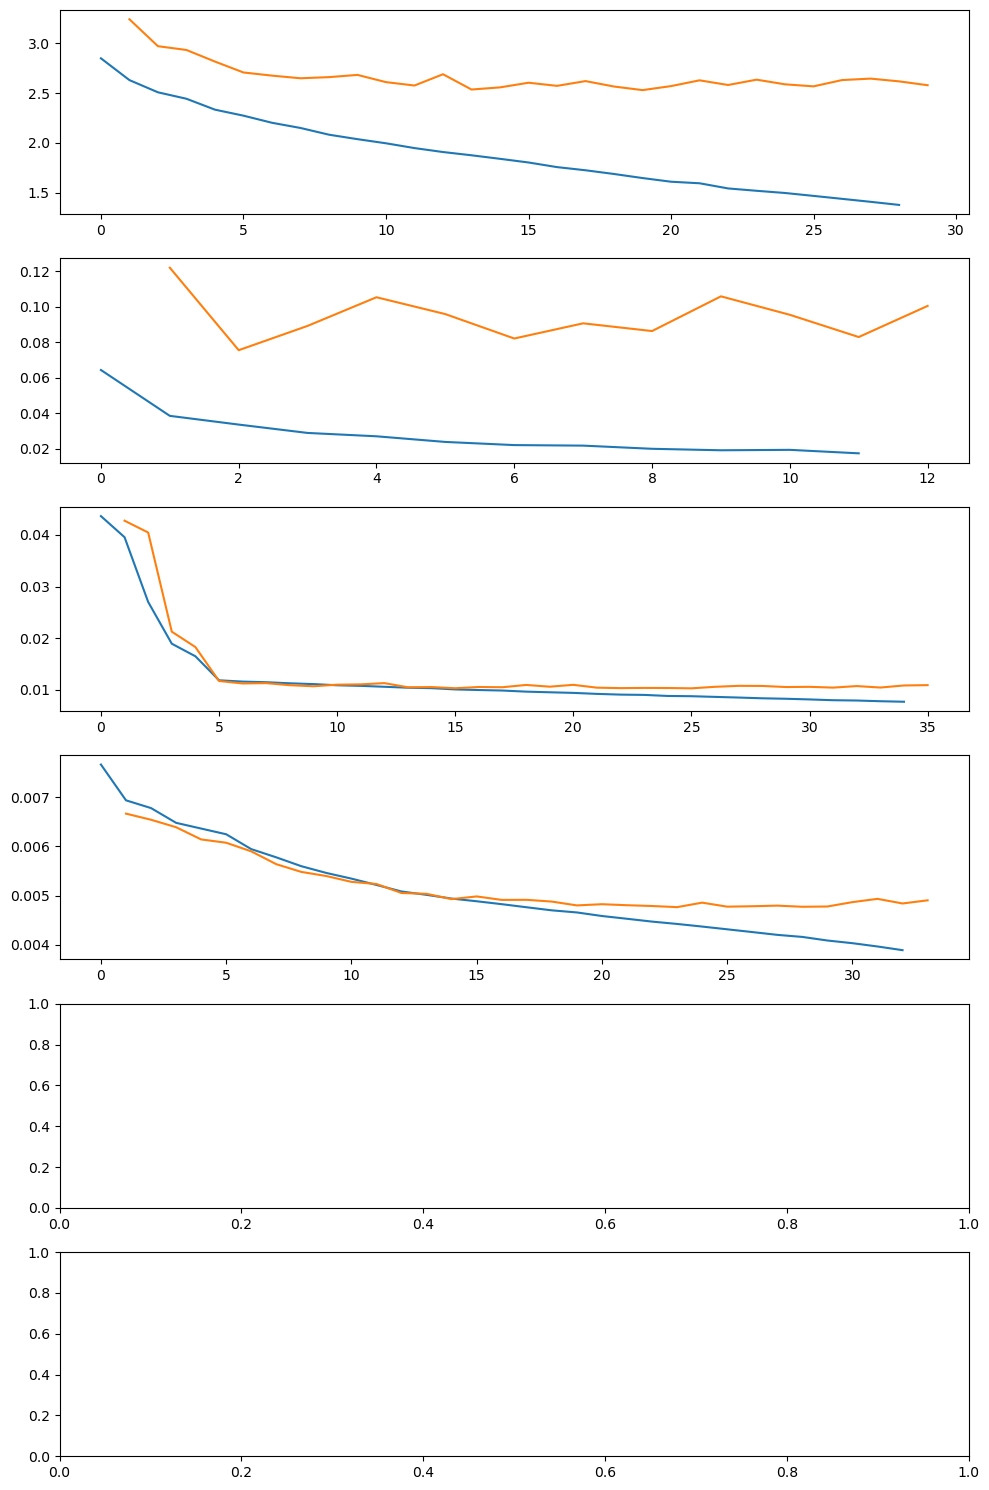

In [15]:
NUM_EPOCHS = 100
NUM_LAYERS = 2
HIDDEN_SIZE = 2048

# writer = SummaryWriter()
# writer.flush()

models = []
param_names = EXPRESSIVE_PARAMS
fig, ax = plt.subplots(len(param_names), figsize=(10, 15))
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"device={device}\n\n")

# train model for each parameter
for i, name in enumerate(param_names):
    
    print(f"Training model for {name}\n")
    
    # initialize model and dataloaders
    my_model = LSTMModel(input_size=train_set.feature_size,
                   hidden_size=HIDDEN_SIZE,
                   output_size=train_set.seq_len
                  )
    
    my_model.to(device)
    
    train_set.choose_parameter(name)
    test_set.choose_parameter(name)
    val_set.choose_parameter(name)

    train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
    val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    learning_rate = 1e-4
    optimizer = optim.Adam(my_model.parameters(), lr=learning_rate)

    # Training loop
    my_model.to(device)

    train_losses = []
    val_losses = [np.inf]
    best_model = None
    best_val_loss = np.inf

    # Train/Validation loop
    for epoch in range(NUM_EPOCHS):

        # Training
        total_train_loss = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = inputs.float(), targets.float()
            
            # Forward pass
            outputs = my_model(inputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())  # Assuming the output and target shapes are compatible

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # Validating
        total_val_loss = 0
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = inputs.float(), targets.float()

            # Forward pass
            outputs = my_model(inputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())

            total_val_loss += loss.item()

        if total_val_loss / len(val_loader) < best_val_loss:
            best_model = my_model.state_dict()

        if len(val_losses) > 10 and min(val_losses) not in val_losses[-10:]:
            print("Validation loss is increasing, stopping early...")
            break

        print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Average train Loss: {total_train_loss / len(train_loader):.4f}, Average validation Loss: {total_val_loss / len(val_loader):.4f}")
        train_losses.append(total_train_loss / len(train_loader))
        val_losses.append(total_val_loss / len(val_loader))
        
        """writer.add_scalars(f"Train loss vs. validation loss {name} ({my_model.model_name})", {"train loss": total_train_loss / len(train_loader),
                                                                      "val loss": total_val_loss / len(val_loader)}, epoch)"""
        

    print("Training finished\n")
    torch.save(best_model, os.path.join("models", f"{my_model.model_name}_best_model_{name}.pt"))

    # Testing
    my_model.load_state_dict(best_model)
    
    total_test_loss = 0
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets = inputs.float(), targets.float()

        # Forward pass
        outputs = my_model(inputs)
        loss = criterion(outputs.squeeze(), targets.squeeze())

        total_test_loss += loss.item()

    print(f"Average loss on test set: {total_test_loss / len(test_loader)}\n\n")
    models.append(my_model)
    
    # writer.add_graph(my_model, input_to_model=inputs)
    
    ax[i].plot(train_losses)
    ax[i].plot(val_losses)
    
fig.tight_layout()
# writer.close()

In [ ]:
torch.save(best_model, os.path.join("models", f"{my_model.model_name}_best_model_{name}.pt"))

In [16]:
class PredictionDataset(Dataset):
    
    def __init__(self,
                 xml_paths,
                 seq_len,
                 fixed_features=True,
                 feat_names="all",
                 drop_feats=[]
                ):   
        
        self.xml_paths = xml_paths
        self.data = []
        
        self.feature_size = 0
        self.seq_len = seq_len
        
        print("Processing score data...")
        for xml in tqdm(xml_paths):

            score = pt.load_score(xml)
            score = pt.score.merge_parts(score)
            
            part = pt.score.unfold_part_maximal(score)
            pt.score.expand_grace_notes(score)

            basis, bf_names = pt.musicanalysis.make_note_feats(part, "all", force_fixed_size=True)

            basis = pd.DataFrame(basis, columns=bf_names)
            basis = basis.drop(columns=drop_feats).to_numpy()

            padding_len = len(basis) % seq_len

            bm_padding_array = np.zeros(shape=(seq_len - padding_len, basis.shape[1]))
            new_basis = np.vstack((basis, bm_padding_array))
            new_basis = np.split(new_basis, len(new_basis) / seq_len)

            self.data += [basis for basis in new_basis]
        
        # applying feature padding if needed
        max_features = max([basis.shape[1] for basis in self.data])
        self.feature_size = max_features
        
        for i, basis in enumerate(self.data):
            if basis.shape[1] < max_features:
                
                difference = max_features - basis.shape[1]
                
                self.data[i] = np.hstack((basis, np.zeros(shape=(seq_len, difference))))
        
    def __getitem__(self, idx):
        return self.data[idx]
    
    def __len__(self):
        return len(self.data)

In [22]:
def generate_midi(model,
                  model_state_dicts,
                  xml_path: str,
                  seq_len: int,
                  drop_feats: list,
                  exp_params: list,
                  save_to: str = ""):
    
    preds = {name: [] for name in exp_params}
    ground_truths = {name: [] for name in exp_params}

    device = "cuda" if torch.cuda.is_available() else "cpu"

    dataset = PredictionDataset([xml_path], seq_len=seq_len, drop_feats=drop_feats)
    
    # save to folder "midi_files" by default
    if save_to == "":
        os.makedirs("midi_files", exist_ok=True)
        piece_name = "_".join(xml_path.split(os.sep)[1:-1]) + ".mid"
        
        save_to = os.path.join("midi_files", piece_name)
    
    # load model_dict corresponding to each parameter and predict
    for model_dict, name in zip(model_state_dicts, exp_params):
        
        model.load_state_dict(torch.load(model_dict))
        dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

        print(f"Predicting {name}...")
        for inputs in tqdm(dataloader):

            inputs = inputs.to(device)
            inputs = inputs.float()

            model.to(device)
            outputs = model(inputs)
            outputs = outputs.view(1, seq_len)

            preds[name] += outputs.tolist()[0]
    
    test_perf = list(zip(*[preds[name] for name in exp_params]))
    
    custom_dtype = np.dtype([*[(name, "<f4") for name in exp_params]])
    
    # sanitizing
    test_perf = np.array(test_perf, dtype=custom_dtype)
    if "beat_period_ratio" in exp_params:
        test_perf["beat_period_ratio"] = np.abs(test_perf["beat_period_ratio"])
    if "beat_period" in exp_params:
        test_perf["beat_period"] = np.abs(test_perf["beat_period"])
    if "velocity_trend" in exp_params:
        test_perf["velocity_trend"] = np.abs(test_perf["velocity_trend"])
    if "velocity_dev" in exp_params:
        test_perf["velocity_dev"] = np.abs(test_perf["velocity_dev"])
    
    # loading the score for decoding
    score = pt.load_score(xml_path)
    score = pt.score.merge_parts(score)
    pt.score.expand_grace_notes(score)

    part = pt.score.unfold_part_maximal(score)

    pc = get_performance_codec(exp_params)
    
    # padding if predicted performance is shorter than score
    padding = (0. for name in exp_params)
    if len(part.notes) > len(test_perf):
        diff = len(part.notes) - len(test_perf)
        print(diff)
        
        padding = [(0. for name in exp_params) for i in range(diff)]
        
        np.append(test_perf, padding)
            
    result = pc.decode(part, test_perf)
        
    pt.save_performance_midi(result, save_to)
    print(f"\nMidi was saved at {os.path.abspath(save_to)}")
    
    return test_perf

In [23]:
model = LSTMModel(input_size=test_set.feature_size, output_size=test_set.seq_len, hidden_size=2048)
model_state_dicts = [f"models\\{model.model_name}_best_model_{name}.pt" for name in EXPRESSIVE_PARAMS]
test_piece = "asap-dataset\\Schumann\\Arabeske\\xml_score.musicxml"

generate_midi(
    model=model,
    model_state_dicts=model_state_dicts,
    xml_path=test_piece,
    seq_len=test_set.seq_len,
    drop_feats=drop_cols,
    exp_params=EXPRESSIVE_PARAMS,
    save_to="Transformer_midi.mid"
)

Processing score data...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]


Predicting beat_period_ratio...


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:04<00:00, 13.69it/s]


Predicting timing...


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.07it/s]


Predicting articulation_log...


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.51it/s]


Predicting beat_period_mean...


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 17.22it/s]


Predicting velocity_trend...


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.22it/s]


Predicting velocity_dev...


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:04<00:00, 14.72it/s]


126

Midi was saved at C:\Users\Max\Desktop\Uni\basismixer\Transformer_midi.mid


True

In [24]:
test_set.xml_paths

['asap-dataset\\Bach\\Fugue\\bwv_892\\xml_score.musicxml',
 'asap-dataset\\Chopin\\Ballades\\1\\xml_score.musicxml',
 'asap-dataset\\Liszt\\Transcendental_Etudes\\10\\xml_score.musicxml',
 'asap-dataset\\Bach\\Fugue\\bwv_870\\xml_score.musicxml',
 'asap-dataset\\Schubert\\Impromptu_op.90_D.899\\2\\xml_score.musicxml',
 'asap-dataset\\Bach\\Prelude\\bwv_857\\xml_score.musicxml',
 'asap-dataset\\Liszt\\Ballade_2\\xml_score.musicxml',
 'asap-dataset\\Bach\\Prelude\\bwv_863\\xml_score.musicxml',
 'asap-dataset\\Schumann\\Arabeske\\xml_score.musicxml',
 'asap-dataset\\Beethoven\\Piano_Sonatas\\31-3_4\\xml_score.musicxml',
 'asap-dataset\\Bach\\Prelude\\bwv_889\\xml_score.musicxml',
 'asap-dataset\\Chopin\\Barcarolle\\xml_score.musicxml',
 'asap-dataset\\Beethoven\\Piano_Sonatas\\26-1\\xml_score.musicxml',
 'asap-dataset\\Bach\\Prelude\\bwv_892\\xml_score.musicxml',
 'asap-dataset\\Liszt\\Transcendental_Etudes\\5\\xml_score.musicxml']

In [26]:
model = LSTMSeq2Seq(input_size=test_set.feature_size, output_size=test_set.seq_len, hidden_size=1024)
model_state_dicts = [f"models\\{model.model_name}_best_model_{name}.pt" for name in EXPRESSIVE_PARAMS]

for piece in test_set.xml_paths:
    
    generate_midi(
        model=model,
        model_state_dicts=model_state_dicts,
        xml_path=piece,
        seq_len=test_set.seq_len,
        drop_feats=drop_cols,
        exp_params=EXPRESSIVE_PARAMS
    )

Processing score data...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


Predicting beat_period_ratio...


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 14.42it/s]


Predicting timing...


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 33.43it/s]


Predicting articulation_log...


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 32.94it/s]


Predicting beat_period_mean...


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 30.83it/s]


Predicting velocity_trend...


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 32.34it/s]


Predicting velocity_dev...


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 32.54it/s]


116

Midi was saved at C:\Users\Max\Desktop\Uni\basismixer\midi_files\Bach_Fugue_bwv_892.mid
Processing score data...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.80s/it]


Predicting beat_period_ratio...


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:04<00:00, 23.03it/s]


Predicting timing...


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:03<00:00, 26.24it/s]


Predicting articulation_log...


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:03<00:00, 28.81it/s]


Predicting beat_period_mean...


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:03<00:00, 30.26it/s]


Predicting velocity_trend...


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:03<00:00, 27.00it/s]


Predicting velocity_dev...


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:03<00:00, 26.36it/s]


62

Midi was saved at C:\Users\Max\Desktop\Uni\basismixer\midi_files\Chopin_Ballades_1.mid
Processing score data...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.46s/it]


Predicting beat_period_ratio...


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:03<00:00, 26.09it/s]


Predicting timing...


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 29.73it/s]


Predicting articulation_log...


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 28.85it/s]


Predicting beat_period_mean...


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 30.88it/s]


Predicting velocity_trend...


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 31.52it/s]


Predicting velocity_dev...


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 30.29it/s]



Midi was saved at C:\Users\Max\Desktop\Uni\basismixer\midi_files\Liszt_Transcendental_Etudes_10.mid
Processing score data...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


Predicting beat_period_ratio...


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 18.80it/s]


Predicting timing...


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 29.70it/s]


Predicting articulation_log...


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 30.15it/s]


Predicting beat_period_mean...


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 31.63it/s]


Predicting velocity_trend...


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 30.66it/s]


Predicting velocity_dev...


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 35.17it/s]



Midi was saved at C:\Users\Max\Desktop\Uni\basismixer\midi_files\Bach_Fugue_bwv_870.mid
Processing score data...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/it]


Predicting beat_period_ratio...


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 24.75it/s]


Predicting timing...


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 29.76it/s]


Predicting articulation_log...


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 32.23it/s]


Predicting beat_period_mean...


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 31.09it/s]


Predicting velocity_trend...


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 29.68it/s]


Predicting velocity_dev...


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 28.38it/s]



Midi was saved at C:\Users\Max\Desktop\Uni\basismixer\midi_files\Schubert_Impromptu_op.90_D.899_2.mid
Processing score data...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Predicting beat_period_ratio...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 18.45it/s]


Predicting timing...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 22.32it/s]


Predicting articulation_log...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 28.17it/s]


Predicting beat_period_mean...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 26.08it/s]


Predicting velocity_trend...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 28.48it/s]


Predicting velocity_dev...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 29.12it/s]



Midi was saved at C:\Users\Max\Desktop\Uni\basismixer\midi_files\Bach_Prelude_bwv_857.mid
Processing score data...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.90s/it]


Predicting beat_period_ratio...


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [00:05<00:00, 29.02it/s]


Predicting timing...


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [00:05<00:00, 29.36it/s]


Predicting articulation_log...


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [00:05<00:00, 25.19it/s]


Predicting beat_period_mean...


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [00:06<00:00, 22.26it/s]


Predicting velocity_trend...


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [00:05<00:00, 24.89it/s]


Predicting velocity_dev...


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [00:05<00:00, 24.90it/s]


278

Midi was saved at C:\Users\Max\Desktop\Uni\basismixer\midi_files\Liszt_Ballade_2.mid
Processing score data...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Predicting beat_period_ratio...


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.99it/s]


Predicting timing...


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.12it/s]


Predicting articulation_log...


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 34.82it/s]


Predicting beat_period_mean...


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 35.71it/s]


Predicting velocity_trend...


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.46it/s]


Predicting velocity_dev...


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 34.45it/s]


11

Midi was saved at C:\Users\Max\Desktop\Uni\basismixer\midi_files\Bach_Prelude_bwv_863.mid
Processing score data...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.10s/it]


Predicting beat_period_ratio...


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 17.86it/s]


Predicting timing...


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:02<00:00, 23.63it/s]


Predicting articulation_log...


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:02<00:00, 22.68it/s]


Predicting beat_period_mean...


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:02<00:00, 25.45it/s]


Predicting velocity_trend...


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:02<00:00, 22.86it/s]


Predicting velocity_dev...


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:02<00:00, 24.12it/s]


126

Midi was saved at C:\Users\Max\Desktop\Uni\basismixer\midi_files\Schumann_Arabeske.mid
Processing score data...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/it]


Predicting beat_period_ratio...


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [00:03<00:00, 21.02it/s]


Predicting timing...


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [00:03<00:00, 19.48it/s]


Predicting articulation_log...


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [00:03<00:00, 22.55it/s]


Predicting beat_period_mean...


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [00:03<00:00, 24.03it/s]


Predicting velocity_trend...


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [00:03<00:00, 24.58it/s]


Predicting velocity_dev...


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [00:03<00:00, 23.92it/s]


224

Midi was saved at C:\Users\Max\Desktop\Uni\basismixer\midi_files\Beethoven_Piano_Sonatas_31-3_4.mid
Processing score data...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Predicting beat_period_ratio...


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.70it/s]


Predicting timing...


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 20.90it/s]


Predicting articulation_log...


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.59it/s]


Predicting beat_period_mean...


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.03it/s]


Predicting velocity_trend...


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 22.36it/s]


Predicting velocity_dev...


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 21.90it/s]


48

Midi was saved at C:\Users\Max\Desktop\Uni\basismixer\midi_files\Bach_Prelude_bwv_889.mid
Processing score data...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.00s/it]


Predicting beat_period_ratio...


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 20.82it/s]


Predicting timing...


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 24.03it/s]


Predicting articulation_log...


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 21.16it/s]


Predicting beat_period_mean...


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 24.01it/s]


Predicting velocity_trend...


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:03<00:00, 25.99it/s]


Predicting velocity_dev...


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:04<00:00, 24.48it/s]


64

Midi was saved at C:\Users\Max\Desktop\Uni\basismixer\midi_files\Chopin_Barcarolle.mid
Processing score data...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  4.00s/it]


Predicting beat_period_ratio...


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:03<00:00, 20.74it/s]


Predicting timing...


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.71it/s]


Predicting articulation_log...


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.00it/s]


Predicting beat_period_mean...


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 29.40it/s]


Predicting velocity_trend...


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:03<00:00, 18.99it/s]


Predicting velocity_dev...


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:03<00:00, 22.41it/s]


64

Midi was saved at C:\Users\Max\Desktop\Uni\basismixer\midi_files\Beethoven_Piano_Sonatas_26-1.mid
Processing score data...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


Predicting beat_period_ratio...


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 17.77it/s]


Predicting timing...


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 22.94it/s]


Predicting articulation_log...


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 29.99it/s]


Predicting beat_period_mean...


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 30.44it/s]


Predicting velocity_trend...


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 26.07it/s]


Predicting velocity_dev...


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 26.79it/s]



Midi was saved at C:\Users\Max\Desktop\Uni\basismixer\midi_files\Bach_Prelude_bwv_892.mid
Processing score data...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.86s/it]


Predicting beat_period_ratio...


100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [00:03<00:00, 23.89it/s]


Predicting timing...


100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [00:03<00:00, 25.25it/s]


Predicting articulation_log...


100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [00:03<00:00, 23.86it/s]


Predicting beat_period_mean...


100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [00:03<00:00, 24.75it/s]


Predicting velocity_trend...


100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [00:03<00:00, 28.32it/s]


Predicting velocity_dev...


100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [00:03<00:00, 25.67it/s]


10

Midi was saved at C:\Users\Max\Desktop\Uni\basismixer\midi_files\Liszt_Transcendental_Etudes_5.mid


In [237]:
torch.log(torch.tril(torch.ones(4,4)))

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])